# Baseline Segmentation with K-means Clustering

In [1]:
import glob
import pickle

import numpy as np

from matplotlib.image import imread
import matplotlib.pyplot as plt
from PIL import Image 

import rasterio
from rasterio.plot import show

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Read images as arrays and re-scale

In [2]:
original_images = [] # (1024, 1024, 3)
std_images = [] #standardized
files = glob.glob('/home/dssg-reglab/notebooks/home/segmentation_ground_truth/*.jpg')
for file in files:
    image = imread(file)
    #normalize
    original_images.append(image/255.0)
    #standardize
    image = (image - image.mean())/image.std()
    std_images.append(image)

In [3]:
def generate_coords(image):
    rows = np.arange(image.shape[0])
    cols =  np.arange(image.shape[1])
    coords = np.empty((len(rows), len(cols), 2), dtype=np.intp)
    coords[..., 0] =  rows[:, None]
    coords[..., 1] = cols
    #standardize
    coords = (coords - coords.mean())/coords.std()
    return coords

In [57]:
# images = [] #(1024*1024, 5)
# images_1 = [] #0.5 weight
# images_2 = [] #1.5
# images_3 = [] #2

# coords = generate_coords(std_images[0]) #same for all imgs

# for image in std_images:
#     #concantenate location info
#     images.append(np.dstack((image, coords)).reshape(-1, 5))
#     images_1.append(np.dstack((image, 2*coords)).reshape(-1, 5))
#     images_2.append(np.dstack((image, 3*coords)).reshape(-1, 5))
#     images_3.append(np.dstack((image, 4*coords)).reshape(-1, 5))

In [60]:
# all_images = [] #list of list of images w/ different loc weights
# all_images.append(images)
# all_images.append(images_1)
# all_images.append(images_2)
# all_images.append(images_3)

In [58]:
#save
with open('all_images.pkl', 'wb') as f:
    pickle.dump(all_images, f)

In [47]:
#load
with open('all_images.pkl', 'rb') as f:
    all_images = pickle.load(f)

In [4]:
images = [] #list of (1024*1024, 5)

coords = generate_coords(std_images[0]) #same for all imgs

for image in std_images:
    #concantenate location info
    images.append(np.dstack((image, 3*coords)).reshape(-1, 5))

### Segmentation w/ K-means

In [7]:
def segment(image, k, shape, threshold):  
    km = KMeans(n_clusters = k)
    km.fit(image)
    centers = km.cluster_centers_

#     brightest = 0
#     brightest_i = 0
#     new_centers = [0 for c in centers]
#     for j, center in enumerate(centers):
#         #only look at first three values (R,G,B)
#         if sum(center[:3]) > brightest:
#             brightest = sum(center[:3])
#             brightest_i = j
#     print('bright', brightest)
#     if brightest > 1.5:
#         new_centers[brightest_i] = 1
#     new_centers[brightest_i] = 1
 
    new_centers = [0 for c in centers]
    brightest_i = []
    for j, center in enumerate(centers):
        #only look at first three values (R,G,B)
        if sum(center[:3]) > threshold:
            brightest_i.append(j)
      
    #print(brightest_i)
    for i in brightest_i:
        new_centers[i] = 1 
    
    centers = new_centers
    centers = np.array(centers)
    
    #replace each pixel with the values of its cluster center (1 or 0)
    seg_image = centers[km.labels_]

    mask_proportion = np.sum(seg_image)/(shape[0]*shape[1]*1.0)
    
    #only detect cafos if predicted cafo proportion < 5% of image - avoid classifying image w/ white background/clouds
    if mask_proportion < 0.05:
        #print(mask_proportion)
        seg_image = seg_image.reshape(shape[0], shape[1])
    else:
        seg_image = np.zeros([shape[0], shape[1]])
    
    #print(mask_proportion)
    seg_image = seg_image.reshape(shape[0], shape[1])
    
    return seg_image

In [10]:
masks = []
for i, image in enumerate(images):
#     plt.imshow(original_images[i])
#     plt.show()
    mask = segment(image, 40, [1024, 1024], 7.5)
    masks.append(mask)
#    plt.savefig('../../segmented/' + str(i).zfill(3) + '.png', dpi=200)
#     plt.imshow(mask, cmap='rainbow', alpha=.5)
#     plt.show()
#     if i == 4:
#         break

In [11]:
with open('loc_masks.pkl', 'wb') as f:
    pickle.dump(masks, f)

# Validating against ground truth labels

### Load masks (ground truth)

In [12]:
#hack to load masks in right order
mturk_files = glob.glob('/home/dssg-reglab/notebooks/home/segmentation_ground_truth/*.jpg')

true_masks = []
for filename in mturk_files:
    filename = filename.replace('.jpg', '.p')
    ground_truth = pickle.load(open(filename, "rb" ))
    mask = ground_truth['masks']['CAFO Shed'] 
    true_masks.append(mask)

### Evaluation Metrics

In [13]:
pixel_accuracy = accuracy_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())
precision = precision_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())
recall = recall_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())

SMOOTHING = 1
coeff_sum = 0
for i in range(len(masks)):
    pred_mask = masks[i]
    true_mask = true_masks[i]
    img = images[i] 
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    coeff_sum += (intersection.sum() + SMOOTHING) / (union.sum() + SMOOTHING)
mean_iou = coeff_sum / len(masks)

print("Pixel accuracy: ", pixel_accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("Mean IOU: ", mean_iou)

Pixel accuracy:  0.9864438091005597
Precision:  0.21063163170826155
Recall:  0.6775515559813566
Mean IOU:  0.2026750018754366


# Prediction on satellite images

In [15]:
files = glob.glob('/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2020/*')    

satellite_originals = []
satellite_images = []
for file in files:
    image = rasterio.open(file)
    r,g,b,n = image.read()
    image = np.stack((r,g,b), axis=2)
    #normalize
    image = image/image.max()
    satellite_originals.append(image)
    image = (image - image.mean())/image.std()
    
    coords = generate_coords(image)
    
    image = np.dstack((image, 3*coords))  
    
    satellite_image = image.reshape(-1, image.shape[-1])
    satellite_images.append(satellite_image)


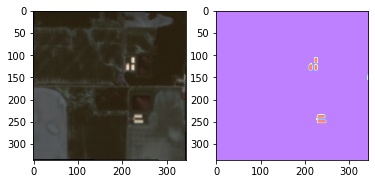

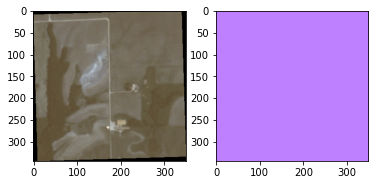

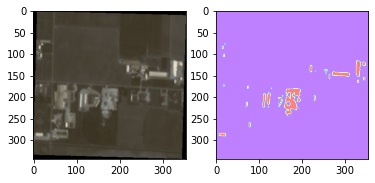

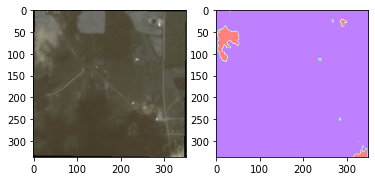

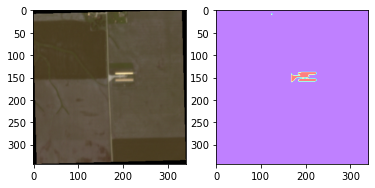

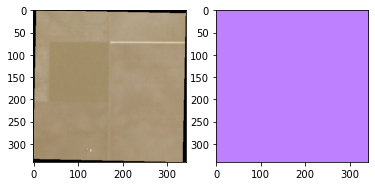

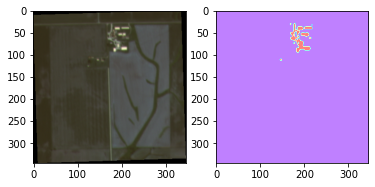

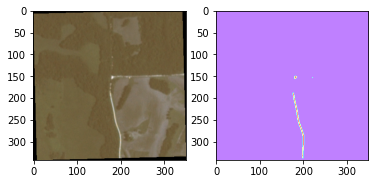

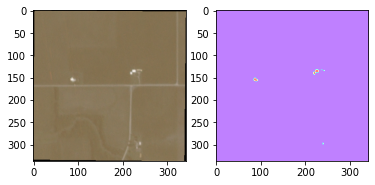

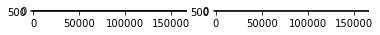

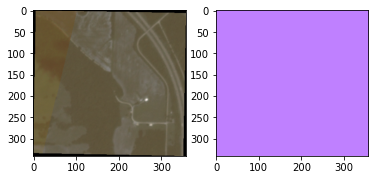

In [24]:
#pred_masks = [] 
for i, img in enumerate(satellite_images):
    f = plt.figure()
    ax1 = f.add_subplot(1,2,1)
    ax1 = ax1.imshow(satellite_originals[i])

    mask = segment(img, 40, satellite_originals[i].shape, 6)
    #pred_masks.append(mask)
    #plt.savefig('../../planet-segmented/' + str(i).zfill(3) + '.png', dpi=200)
    ax2 = f.add_subplot(1,2,2)
    ax2 = ax2.imshow(mask, cmap='rainbow', alpha=.5)
    plt.show()
    
    if i == 10:
        break